In [1]:
import os
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import Audio, display, clear_output, HTML
import math
import numpy as np
import pandas as pd
from scipy import signal
#import seaborn as sns
import matplotlib.ticker as ticker
#sns.set(font_scale=1.2)
import pickle
import time
import shutil
from cepstrum import cepstrum
import glob
import re
import umap
import umap.plot
from pylab import rcParams
import cufflinks as cf
import hvplot
import hvplot.pandas
cf.set_config_file(sharing='public',theme='ggplot',offline=True)
import holoviews as hv
from holoviews import dim, opts
hv.extension('bokeh')
from scipy.integrate import simps
from numpy import pi as PI

In [2]:
class Station:
    
    def __init__(self, name, thrshold):
        self.name = name
        self.thrshold = thrshold
        self.events = []
        
    def set_event(self, event):
        if (event.duration >= self.thrshold):
            self.events.append(event)

class Event:
    
    def __init__(self, name, wav_dir, station):
        self.name = name
        self.station = station
        self.kind = '' # it will be the original wav file name
        self.duration = 0.0
        self.power = 0.0
        self.calculator(name, wav_dir)
    
    def calculator(self, audio, wav_dir):
        self.kind_set(audio)
        self.audio_average_power(wav_dir)
    
    def audio_average_power(self, wav_dir):
         
        main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
        #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"

        wav_path = os.path.join(main + wav_dir, self.name)
        waveform, sample_rate = torchaudio.load(wav_path)
        num_channels, num_frames = waveform.shape
        
        if waveform.numpy().shape[1] != 0:
            
            ft_wf = np.fft.fft(waveform.numpy())/(math.sqrt(waveform.numpy().shape[1]))
            
            parseval_waveform = np.sum(waveform.numpy()**2)
            parseval_fourier_transform = np.sum(np.abs(ft_wf)**2)
            
            if (np.float32(round(parseval_waveform,1)) == np.float32(round(parseval_fourier_transform,1))):
                
                self.power = parseval_waveform
                
                duration = torch.arange(0, num_frames) / sample_rate
                self.duration = duration.numpy()[-1]
            
    def kind_set(self, audio):
        text = audio.split('_')
        self.kind = text[2]

def folders(wav_dir, station):
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    wav_noise_names = os.listdir(wav_dir + noise)
    wav_not_noise_names = os.listdir(wav_dir + not_noise)
    
    print(station.name, " -> In Noise folder")
    
    for w in wav_noise_names:
        station.set_event(Event(w, wav_dir + noise, station.name))
    
    print(station.name, " -> In Not Noise folder")
    
    for nn in wav_not_noise_names:
        station.set_event(Event(nn, wav_dir + not_noise, station.name))
    
    return station

def dataframer(stations):
    
    thrshold = 0.5
    data = []
    framer = []
    
    for s in stations:
        
        data.clear()
        
        for e in s.events:
            
            if e.duration >= thrshold:
                data.append([s.name, e.name, e.kind, e.duration, e.power])
        
        framer.append(pd.DataFrame(data.copy(), columns = ['station', 'audio', 'class', 'duration', 'power']))
    
    return framer

#returns a slice of dataframes!!
def _initiator(thrshold):
    
    stations = []
    fls = []

#     main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
#     wav_dir = '/home/kasparov/Documentos/20190114_vpoblete/20221019_Wasserstein/'
    
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")
    
    
    for f in fls:
        stations.append(Station(f.split("_")[8], thrshold))
    
    for s in stations:
        
        for f in fls:
            if(f.split("_")[8] == s.name):
                print("Working in: ", s.name)
                s = folders(f, s)
                break
            
    return stations, fls

def _writer(stations):
    
    filewriter = open("stations/stations.fusa", "wb")
    stations = pickle.dump(stations, filewriter)
    filewriter.close()
    
def _npzwriter(stations):
    
    filewriter = open("stations/npz_stations.fusa", "wb")
    stations = pickle.dump(stations, filewriter)
    filewriter.close()
    
def _reader(file):
    
    filereader = open("stations/" + file, "rb")
    stations = pickle.load(filereader)
    filereader.close()
    
    return stations

def _copier(stations, fls):
    
    main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    for s in stations:
        counter = 0
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    counter = counter + 1

                    if("ruido" in e.name):
                        item = main+f+noise+e.name
                        shutil.copy(item, main+"stations/"+noise)
                        break
                    else:
                        item = main+f+not_noise+e.name
                        shutil.copy(item, main+"stations/"+not_noise)
                        break
                        
def _npz_copier(stations, fls):
    
    main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    counter_noise = 0
    counter_event = 0
    for s in stations:
        counter = 0
        
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    counter += 1
                    if("ruido" in e.name):
                        item = main+f+noise
                        filename = item+e.name
                        newit = main + "stations/" + noise
                        setattr(e, 'kind', e.name)
                        cep_filename = cepstrum(filename)
                        setattr(e, 'name', 'noise'+str(counter_noise)+'.npz')
                        newfile = newit + getattr(e, 'name')
                        np.savez(newfile, cep_filename)
                        counter_noise += 1
                    
                        break
                        
                    else:
                        item = main+f+not_noise
                        filename = item+e.name
                        newit = main + "stations/" + not_noise
                        setattr(e, 'kind', e.name)
                        cep_filename = cepstrum(filename)
                        setattr(e, 'name', 'event'+str(counter_event)+'.npz')
                        newfile = newit + getattr(e,'name')
                        np.savez(newfile, cep_filename)
                        counter_event += 1
                        break
            
    return stations


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
     (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def big_matrix():
    
#     npzfilespath =r"/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/stations/ruido/"  
    npzfilespath = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    
    os.chdir(npzfilespath)
    npfiles= glob.glob("*.npz")
    npfiles.sort(key=natural_keys)
    all_arrays = []
    #print(npfiles)
    
    for i, npfile in enumerate(npfiles):
        #print(npfile)
        X = np.load(os.path.join(npzfilespath, npfile))
        #print(X)
        #print(len(X['arr_0']))
        all_arrays.append(X['arr_0'])
    
    big_matrix = np.array(all_arrays)
    np.savez('big_matrix_noise',big_matrix)
    print(big_matrix.shape)
    
def categorizer(row):
    
    if (row['station'] == 'ronda1/' or row['station'] == 'ronda2/'):
        
        return 'sensor_1' #'capta_002'
    
    elif (row['station'] == 'ronda3/' or row['station'] == 'ronda6/'):
        
        return 'sensor_2' #'capta'
    
    elif (row['station'] == 'ronda4/'):
        
        return 'sensor_3' #'control_acustico'
    
    elif (row['station'] == 'ronda5/'):
        
        return 'sensor_4' #'mma'
    
    print('falla')
    
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1, figsize=(10,2))
    axes.plot(time_axis, waveform[0], linewidth=1, color='k')
    #axes.grid(True)
    figure.suptitle(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show(block=False)
    
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None, ylim=True):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(10,2))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate, cmap='Greys')
        axes[c].set_yscale('log')
        
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        #axes[c].set_ylim(ylim)
        axes[c].set_ylim([500, 10000])
    figure.suptitle(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.show(block=False)

In [ ]:
start = time.time()

stations, fls = _initiator(0.5)

end = time.time()

print(round(end-start,1))

_writer(stations)

In [ ]:
stations = _reader('stations.fusa')

In [3]:
fls=[]
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")

In [ ]:
stations

In [ ]:
npz_station = _npz_copier(stations, fls)
_npzwriter(npz_station)

In [ ]:
df = dataframer(stations)

In [4]:
npz_stations = _reader('npz_stations.fusa')
df_npz = dataframer(npz_stations)
df_npz

[      station          audio  \
 0     ronda1/     noise0.npz   
 1     ronda1/     noise1.npz   
 2     ronda1/     noise2.npz   
 3     ronda1/     noise3.npz   
 4     ronda1/     noise4.npz   
 ...       ...            ...   
 1262  ronda1/  event1016.npz   
 1263  ronda1/  event1017.npz   
 1264  ronda1/  event1018.npz   
 1265  ronda1/  event1019.npz   
 1266  ronda1/  event1020.npz   
 
                                                  class   duration      power  
 0                  1653712794_1653712854_ruido_223.wav  13.647708   0.754834  
 1                  1653789034_1653789094_ruido_417.wav   2.769979   0.419892  
 2                  1653706209_1653706269_ruido_160.wav  27.045750   1.402200  
 3                 1655255968_1655256028_ruido_1248.wav   4.182500   0.074135  
 4                 1655063894_1655063954_ruido_1159.wav   1.474979   0.218602  
 ...                                                ...        ...        ...  
 1262  1655234087_1655234147_Camion_movimi

In [ ]:
big_matrix()

In [ ]:
n_1 =50
m_1 =0.2

n_2 =40
m_2 =0.2

n_3 =30
m_3 =0.2

n_4 =40
m_4 =0.2

n_5 =50
m_5 =0.2

In [ ]:
path_bm = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/stations/matrix/'
#path_bm = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/stations/matrix/"
noises = np.load(path_bm + 'big_matrix_noise.npz')
X = noises['arr_0']
embedding = umap.UMAP(n_neighbors = 50,
                        min_dist  = 0.8,
                        verbose = True,
                        metric='correlation').fit(X)

emb_filename = "stations/embedding.fusa"

pickle.dump(embedding, open(emb_filename, "wb"))

In [5]:
emb_filename = "stations/embedding.fusa"
embedding = pickle.load(open(emb_filename, "rb"))

In [6]:
frame = [df_npz[0], df_npz[1], df_npz[2], df_npz[3], df_npz[4], df_npz[5]]
df = pd.concat(frame)
df['station_name'] = df.apply(lambda row: categorizer(row), axis=1)
df.sort_values(by=['audio'])
df

station          audio  \
0     ronda1/     noise0.npz   
1     ronda1/     noise1.npz   
2     ronda1/     noise2.npz   
3     ronda1/     noise3.npz   
4     ronda1/     noise4.npz   
...       ...            ...   
1998  ronda6/  event7674.npz   
1999  ronda6/  event7675.npz   
2000  ronda6/  event7676.npz   
2001  ronda6/  event7677.npz   
2002  ronda6/  event7678.npz   

                                                  class   duration  \
0                   1653712794_1653712854_ruido_223.wav  13.647708   
1                   1653789034_1653789094_ruido_417.wav   2.769979   
2                   1653706209_1653706269_ruido_160.wav  27.045750   
3                  1655255968_1655256028_ruido_1248.wav   4.182500   
4                  1655063894_1655063954_ruido_1159.wav   1.474979   
...                                                 ...        ...   
1998         62e39b767a2acbde063ecf57_Multitud_1166.wav  10.960229   
1999  62e4c87f7a2acbde063ed7a9_Camion_movimiento_202...  11.274271   
2000           62e3d6127a2acbde063ed23a_Camion_1479.wav  29.999979   
2001  62e23bd47a2acbde063eca5b_Automovil_movimiento_...  18.013229   
2002            62e4d0347a2acbde063ed8b0_Grito_2117.wav   1.258250   

           power station_name  
0       0.754834     sensor_1  
1       0.419892     sensor_1  
2       1.402200     sensor_1  
3       0.074135     sensor_1  
4       0.218602     sensor_1  
...          ...          ...  
1998  153.902313     sensor_2  
1999  101.971397     sensor_2  
2000  494.117554     sensor_2  
2001   24.495485     sensor_2  
2002   21.542978     sensor_2  

[9473 rows x 6 columns]

In [7]:
data = df[df['audio'].str.contains('noise')]
data

station          audio                                    class  \
0    ronda1/     noise0.npz      1653712794_1653712854_ruido_223.wav   
1    ronda1/     noise1.npz      1653789034_1653789094_ruido_417.wav   
2    ronda1/     noise2.npz      1653706209_1653706269_ruido_160.wav   
3    ronda1/     noise3.npz     1655255968_1655256028_ruido_1248.wav   
4    ronda1/     noise4.npz     1655063894_1655063954_ruido_1159.wav   
..       ...            ...                                      ...   
192  ronda6/  noise1789.npz  62e4bf687a2acbde063ed68c_ruido_1965.wav   
193  ronda6/  noise1790.npz   62e3673c7a2acbde063ecb48_ruido_724.wav   
194  ronda6/  noise1791.npz   62e2175c7a2acbde063ec764_ruido_321.wav   
195  ronda6/  noise1792.npz  62e4b7147a2acbde063ed579_ruido_1864.wav   
196  ronda6/  noise1793.npz  62e4af5c7a2acbde063ed43a_ruido_1724.wav   

      duration     power station_name  
0    13.647708  0.754834     sensor_1  
1     2.769979  0.419892     sensor_1  
2    27.045750  1.402200     sensor_1  
3     4.182500  0.074135     sensor_1  
4     1.474979  0.218602     sensor_1  
..         ...       ...          ...  
192  12.370438  0.873634     sensor_2  
193   0.794667  0.466743     sensor_2  
194   0.582500  0.029089     sensor_2  
195   9.151271  1.930381     sensor_2  
196   4.994479  0.067731     sensor_2  

[1794 rows x 6 columns]

In [ ]:
embedding

In [ ]:
umap.plot.points(embedding, labels = data.station_name,theme='fire')
umap.plot.plt.show()

In [8]:
data["Embedding 0"] = embedding.embedding_[:, 0]
data["Embedding 1"] = embedding.embedding_[:, 1]

In [ ]:
data.plot.scatter(x = "Embedding 0", y = "Embedding 1")

In [ ]:
data.hvplot(kind='scatter', x = 'Embedding 0', y = 'Embedding 1', by = 'station_name')

In [9]:
miniball = data[data['Embedding 0'] < -5]

miniball.to_csv('stations/UMAP_df_separation/miniball.csv') # checkpoints para no tener que correr todo

miniball

station          audio                                   class  duration  \
4    ronda1/     noise4.npz    1655063894_1655063954_ruido_1159.wav  1.474979   
10   ronda1/    noise10.npz     1653787701_1653787761_ruido_366.wav  0.869979   
11   ronda1/    noise11.npz    1653981393_16539814531_ruido_578.wav  0.969521   
12   ronda1/    noise12.npz    1653981393_16539814531_ruido_574.wav  1.258250   
14   ronda1/    noise14.npz    1654238167_16542382271_ruido_724.wav  1.349979   
..       ...            ...                                     ...       ...   
181  ronda6/  noise1778.npz  62df75947a2acbde063ebe2e_ruido_306.wav  0.562292   
187  ronda6/  noise1784.npz  62e380727a2acbde063ecd51_ruido_939.wav  0.755667   
191  ronda6/  noise1788.npz  62e21bc17a2acbde063ec7be_ruido_369.wav  0.528938   
193  ronda6/  noise1790.npz  62e3673c7a2acbde063ecb48_ruido_724.wav  0.794667   
194  ronda6/  noise1791.npz  62e2175c7a2acbde063ec764_ruido_321.wav  0.582500   

         power station_name  Embedding 0  Embedding 1  
4     0.218602     sensor_1   -15.813956    -1.741219  
10    0.041000     sensor_1   -15.585867    -0.264652  
11    0.030351     sensor_1   -15.525416    -3.072181  
12    0.022924     sensor_1   -14.422880    -3.475975  
14    0.069800     sensor_1   -15.513602    -3.420379  
..         ...          ...          ...          ...  
181   0.280692     sensor_2   -14.631388    -3.149362  
187  13.400764     sensor_2   -14.792668    -2.867360  
191   0.121111     sensor_2   -14.960311    -2.605699  
193   0.466743     sensor_2   -14.879652    -2.656835  
194   0.029089     sensor_2   -14.055743    -2.190894  

[699 rows x 8 columns]

In [10]:
upper = data[data['Embedding 0'] > -5]
upper = upper[upper['Embedding 1'] > 10]

upper.to_csv('stations/UMAP_df_separation/upper.csv')

upper

station          audio  \
5    ronda4/  noise1019.npz   
7    ronda4/  noise1021.npz   
8    ronda4/  noise1022.npz   
17   ronda4/  noise1031.npz   
19   ronda4/  noise1033.npz   
..       ...            ...   
264  ronda5/  noise1588.npz   
266  ronda5/  noise1590.npz   
267  ronda5/  noise1591.npz   
269  ronda5/  noise1593.npz   
272  ronda5/  noise1596.npz   

                                                 class  duration     power  \
5    EM2030-00749-2022-06-02T09-57-00-070dB_ruido_7...  2.330083  1.327942   
7    EM2030-00750-2022-06-04T16-50-55-063dB_ruido_8...  3.565104  0.141079   
8    EM2030-00750-2022-05-31T15-43-21-067dB_ruido_7...  3.874156  0.765521   
17   EM2030-00749-2022-07-03T21-45-39-057dB_ruido_6...  2.760042  0.091752   
19   EM2030-00749-2022-07-03T05-40-44-072dB_ruido_6...  2.482646  0.045760   
..                                                 ...       ...       ...   
264  EM2030-00849-2021-07-27T05-28-09-065dB_ruido_1...  4.348771  0.091779   
266  EM2030-00628-2018-12-31T13-50-46-082dB_ruido_7...  1.733688  9.364539   
267  EM2030-00628-2019-01-22T15-29-33-088dB_ruido_1...  2.815531  3.883837   
269  EM2030-00849-2021-06-26T23-19-00-067dB_ruido_1...  6.777031  0.742351   
272  EM2030-00849-2021-10-17T00-12-04-068dB_ruido_1...  3.068427  0.018808   

    station_name  Embedding 0  Embedding 1  
5       sensor_3    -2.276860    17.823650  
7       sensor_3    -0.156225    15.947836  
8       sensor_3    -0.227345    15.219959  
17      sensor_3     0.104499    15.808024  
19      sensor_3     0.094823    16.410866  
..           ...          ...          ...  
264     sensor_4     1.850456    15.193379  
266     sensor_4    -1.683137    17.301620  
267     sensor_4    -2.069870    15.572594  
269     sensor_4     2.402521    15.006608  
272     sensor_4     1.210591    15.779719  

[315 rows x 8 columns]

In [11]:
lower = data[data['Embedding 0'] > -5]
lower = lower[lower['Embedding 1'] < 10]

lower.to_csv('stations/UMAP_df_separation/lower.csv')


lower

station          audio                                    class  \
0    ronda1/     noise0.npz      1653712794_1653712854_ruido_223.wav   
1    ronda1/     noise1.npz      1653789034_1653789094_ruido_417.wav   
2    ronda1/     noise2.npz      1653706209_1653706269_ruido_160.wav   
3    ronda1/     noise3.npz     1655255968_1655256028_ruido_1248.wav   
5    ronda1/     noise5.npz      1654220421_1654220481_ruido_709.wav   
..       ...            ...                                      ...   
189  ronda6/  noise1786.npz   62e21dcb7a2acbde063ec7e7_ruido_401.wav   
190  ronda6/  noise1787.npz   62e218347a2acbde063ec774_ruido_327.wav   
192  ronda6/  noise1789.npz  62e4bf687a2acbde063ed68c_ruido_1965.wav   
195  ronda6/  noise1792.npz  62e4b7147a2acbde063ed579_ruido_1864.wav   
196  ronda6/  noise1793.npz  62e4af5c7a2acbde063ed43a_ruido_1724.wav   

      duration     power station_name  Embedding 0  Embedding 1  
0    13.647708  0.754834     sensor_1     4.350359     4.649143  
1     2.769979  0.419892     sensor_1     2.166908     6.028369  
2    27.045750  1.402200     sensor_1     5.372753     2.973777  
3     4.182500  0.074135     sensor_1     2.887482     4.423066  
5     6.749979  0.995816     sensor_1     3.301937     6.606429  
..         ...       ...          ...          ...          ...  
189   8.758708  0.135892     sensor_2     0.496088     3.705764  
190   8.566688  0.156355     sensor_2     0.005089     3.714127  
192  12.370438  0.873634     sensor_2     6.087706     4.865959  
195   9.151271  1.930381     sensor_2     7.310263     4.812794  
196   4.994479  0.067731     sensor_2     0.335518     4.491185  

[780 rows x 8 columns]

In [ ]:
pd.set_option('display.max_rows', None)
station_audio_to_listen = miniball['station']
station_audio_to_listen

In [ ]:
miniball

In [ ]:
data_miniball = miniball.reset_index()
data_miniball

In [ ]:
data_miniball['station'].loc[0]

In [ ]:
pd.set_option('display.max_rows', None)
audio_listen_to = miniball['class']
audio_listen_to.reset_index()
audio_listen_to

In [ ]:
station_audio_to_listen.loc[10].iat[0]

In [ ]:
data_miniball

In [ ]:
data_miniball.loc[0]

In [ ]:
data_miniball.loc[1].iat[3]

In [ ]:
a = 15
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_miniball['station'].loc[a] + 'ruido/'
wav_file = main + data_miniball.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

In [12]:
data_upper = upper.reset_index()
data_upper 

index  station          audio  \
0        5  ronda4/  noise1019.npz   
1        7  ronda4/  noise1021.npz   
2        8  ronda4/  noise1022.npz   
3       17  ronda4/  noise1031.npz   
4       19  ronda4/  noise1033.npz   
..     ...      ...            ...   
310    264  ronda5/  noise1588.npz   
311    266  ronda5/  noise1590.npz   
312    267  ronda5/  noise1591.npz   
313    269  ronda5/  noise1593.npz   
314    272  ronda5/  noise1596.npz   

                                                 class  duration     power  \
0    EM2030-00749-2022-06-02T09-57-00-070dB_ruido_7...  2.330083  1.327942   
1    EM2030-00750-2022-06-04T16-50-55-063dB_ruido_8...  3.565104  0.141079   
2    EM2030-00750-2022-05-31T15-43-21-067dB_ruido_7...  3.874156  0.765521   
3    EM2030-00749-2022-07-03T21-45-39-057dB_ruido_6...  2.760042  0.091752   
4    EM2030-00749-2022-07-03T05-40-44-072dB_ruido_6...  2.482646  0.045760   
..                                                 ...       ...       ...   
310  EM2030-00849-2021-07-27T05-28-09-065dB_ruido_1...  4.348771  0.091779   
311  EM2030-00628-2018-12-31T13-50-46-082dB_ruido_7...  1.733688  9.364539   
312  EM2030-00628-2019-01-22T15-29-33-088dB_ruido_1...  2.815531  3.883837   
313  EM2030-00849-2021-06-26T23-19-00-067dB_ruido_1...  6.777031  0.742351   
314  EM2030-00849-2021-10-17T00-12-04-068dB_ruido_1...  3.068427  0.018808   

    station_name  Embedding 0  Embedding 1  
0       sensor_3    -2.276860    17.823650  
1       sensor_3    -0.156225    15.947836  
2       sensor_3    -0.227345    15.219959  
3       sensor_3     0.104499    15.808024  
4       sensor_3     0.094823    16.410866  
..           ...          ...          ...  
310     sensor_4     1.850456    15.193379  
311     sensor_4    -1.683137    17.301620  
312     sensor_4    -2.069870    15.572594  
313     sensor_4     2.402521    15.006608  
314     sensor_4     1.210591    15.779719  

[315 rows x 9 columns]

In [13]:
data_lower = lower.reset_index()
data_lower

index  station          audio                                    class  \
0        0  ronda1/     noise0.npz      1653712794_1653712854_ruido_223.wav   
1        1  ronda1/     noise1.npz      1653789034_1653789094_ruido_417.wav   
2        2  ronda1/     noise2.npz      1653706209_1653706269_ruido_160.wav   
3        3  ronda1/     noise3.npz     1655255968_1655256028_ruido_1248.wav   
4        5  ronda1/     noise5.npz      1654220421_1654220481_ruido_709.wav   
..     ...      ...            ...                                      ...   
775    189  ronda6/  noise1786.npz   62e21dcb7a2acbde063ec7e7_ruido_401.wav   
776    190  ronda6/  noise1787.npz   62e218347a2acbde063ec774_ruido_327.wav   
777    192  ronda6/  noise1789.npz  62e4bf687a2acbde063ed68c_ruido_1965.wav   
778    195  ronda6/  noise1792.npz  62e4b7147a2acbde063ed579_ruido_1864.wav   
779    196  ronda6/  noise1793.npz  62e4af5c7a2acbde063ed43a_ruido_1724.wav   

      duration     power station_name  Embedding 0  Embedding 1  
0    13.647708  0.754834     sensor_1     4.350359     4.649143  
1     2.769979  0.419892     sensor_1     2.166908     6.028369  
2    27.045750  1.402200     sensor_1     5.372753     2.973777  
3     4.182500  0.074135     sensor_1     2.887482     4.423066  
4     6.749979  0.995816     sensor_1     3.301937     6.606429  
..         ...       ...          ...          ...          ...  
775   8.758708  0.135892     sensor_2     0.496088     3.705764  
776   8.566688  0.156355     sensor_2     0.005089     3.714127  
777  12.370438  0.873634     sensor_2     6.087706     4.865959  
778   9.151271  1.930381     sensor_2     7.310263     4.812794  
779   4.994479  0.067731     sensor_2     0.335518     4.491185  

[780 rows x 9 columns]

In [ ]:
a = 7
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_upper['station'].loc[a] + 'ruido/'
wav_file = main + data_upper.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

In [ ]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

In [ ]:
waveform_ex = resampled_waveform.numpy()
waveform_ex[0]

In [ ]:
# Fourier transform

FourierCoeff = np.fft.fft(waveform_ex[0])/waveform_ex[0].size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate

Nsamples = int( math.floor(waveform_ex[0].size/2) )
hz = np.linspace(0, resample_rate/2., num = Nsamples + 1 )
dhz = hz[1]

print('Spectral resolution = %2.4f Hz'%dhz)

In [ ]:
# Perform Welch's periodogram
segment = int( resample_rate*0.5 ) 
myhann = signal.get_window('hann', segment)

# obtain simply Power (amplitude^2) withouth tappering
myparams = dict(fs = resample_rate, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'spectrum', return_onesided=True)
freq, ps = signal.welch(x = waveform_ex[0], **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

#obtain Power density (amplitude^2/Hz) withouth tappering
myparams = dict(fs = resample_rate, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = waveform_ex[0], **myparams)# units uV**2/Hz
psd = 2*psd # correct for negative frequencies

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

In [ ]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
#ax[1].semilogx(freq, ps, color='k', lw=2) 
ax[1].plot(freq, ps, color='k', lw=2) 
ax[1].set_ylabel('Power spectrum ($\mu V^2$)')
ax[1].set_xlabel('Frequency (Hz)')

In [ ]:
# Sine wave has an amplitude of 2 uV, the power is 4 uV and the power density is 4*4 because
# we took a segment with size = 4x the sampling rate
print('Signal amplitude     = %.30f uVolts'%amp[int(1.5/dhz)]) 
print('Signal power         = %.30f uVolts^2'%ps[int(1.5/dfreq)])
print('Singal power density = %.30f uVolts^2/Hz'%psd[int(1.5/dfreq)])

In [ ]:
# Perform Welch's periodogram with hann window and 50% overlap
segment = int( 0.5*resample_rate ) 
myhann = signal.get_window('hann', segment)


# obtain simply Power (uV^2) with Hann window and 50% overlap
myparams = dict(fs = resample_rate, nperseg = segment, window = myhann, 
                noverlap = segment/2, scaling = 'spectrum', return_onesided=True)

freq, ps = signal.welch(x = waveform_ex[0], **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

# obtain Power density (uV^2/Hz) with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = resample_rate, nperseg = segment, window = myhann, 
                 noverlap = segment/2, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = waveform_ex[0], **myparams2)# units uV**2
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

In [ ]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
ax[0].semilogx(freq, np.sqrt(ps), color='brown', lw = 2)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power density (Welch's periodogram)")
ax[1].semilogx(freq, psd, color='k', lw=2)

ax[1].set_ylabel('Power spectrum density \n($\mu V^2/Hz$)')

In [ ]:
psd[0]

In [ ]:
normalized_psd = psd / np.linalg.norm(psd)
normalized_psd_dB = 10*np.log10(normalized_psd)

In [ ]:
plt.figure(figsize=(6,4))
#plt.plot(freqs, psd[0], color='k', lw=2)
plt.loglog(freq, normalized_psd, color='k', lw=2, alpha=0.1)
plt.xlabel('Frequency (Hz)')
#plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylabel('Power spectral density (dB / Hz)')
#plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freq.max()])
plt.grid(True)
ax=plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
plt.show(block=False)

In [ ]:
# compute delta-band
idx_delta = np.logical_and(freq >= 600, freq <=1500)
band_power = simps(psd[idx_delta], dx = dfreq)
total_power = simps(psd, dx = dfreq)

print('Absolute power: %.15f uV^2' % band_power)
print('Relative power: %.15f ' % (band_power/total_power))

In [ ]:
# plot in logaritmic scale
plt.figure(figsize=(6,4))
plt.semilogx(freq, normalized_psd_dB, color='k', lw=2, alpha=0.1)
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power density ($dB/Hz)$')
#plt.xlim(0,40), plt.ylim(0.1,1000)
ax=plt.gca()
plt.grid(True)
plt.show(block=False)

In [14]:
# Perform Welch's periodogram with hann window and 50% overlap
def welch_periodogram(wav_file):
    
    waveform, sample_rate = torchaudio.load(wav_file)
    resample_rate = 32000
    resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
    resampled_waveform = resampler(waveform)
    
    segment = int( 0.5*resample_rate ) 
    myhann = signal.get_window('hann', segment)


    # obtain simply Power (uV^2) with Hann window and 50% overlap
    myparams = dict(fs = resample_rate, nperseg = segment, window = myhann, 
                noverlap = segment/2, scaling = 'spectrum', return_onesided=True)

    freq, ps = signal.welch(x = resampled_waveform, **myparams)# units uV**2
    ps = 2*ps # correct for negative frequencies

    # obtain Power density (uV^2/Hz) with Hann window and 50% overlap
    # to get back to simply power, divide by the segment lenght in seconds (four in our case)
    myparams2 = dict(fs = resample_rate, nperseg = segment, window = myhann, 
                 noverlap = segment/2, scaling = 'density', return_onesided=True)
    freq, psd = signal.welch(x = resampled_waveform, **myparams2)# units uV**2
    psd = 2*psd

    dfreq = freq[1]
    #print('Spectral resolution = %2.4f Hz'%dfreq)
    
    normalized_psd = psd / np.linalg.norm(psd)
    normalized_psd_dB = 10*np.log10(normalized_psd)
    
    # plot in logaritmic scale
    ##plt.figure(figsize=(6,4))
    
    ##plt.semilogx(freq, normalized_psd_dB.T, color='k', lw=2, alpha=0.1)
    ##plt.xlabel('Frequency (Hz)'), plt.ylabel('Power density ($dB/Hz)$')
    ##ax=plt.gca()
    ##plt.grid(True)
    ##plt.show(block=False)
    
    #fig=plt.figure()
    #fig.show()
    #ax=fig.add_subplot(111)
    
    #ax.semilogx(freq, normalized_psd_dB.T, color='k', lw=2, alpha=0.1)
    
    return freq, normalized_psd_dB

In [ ]:
data_upper

In [ ]:
data_upper.loc[0].iat[3]

In [ ]:
#main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_upper['station'].loc[a] + 'ruido/'

data_upper['station'].loc[135]

In [ ]:
data_upper_r4 = data_upper[data_upper['station'].str.contains('ronda4')]
print(len(data_upper_r4))

In [ ]:
data_upper_r4

In [ ]:
data_upper_r5 = data_upper[data_upper['station'].str.contains('ronda5')]
print(len(data_upper_r5))

In [ ]:
print(len(data_upper['class']))

In [ ]:
a = 10
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_upper['station'].loc[a] + 'ruido/'
wav_file = main + data_upper.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

In [ ]:
output_welch = welch_periodogram(waveform, sample_rate)


In [ ]:
data_upper['class'][0]

In [ ]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_upper['station'] + 'ruido/'
main

In [ ]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'

print(main + data_upper['station'].loc[134] + 'ruido/' + data_upper.loc[0].iat[3])

In [ ]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig = plt.figure()
mean_value_mma = []
mean_value_ca = []

for f in range(len(data_upper['class'])):
    
    if (data_upper['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_ca.append(normalized_psd_dB)
        #fig.add_subplot(111)
        plt.semilogx(freq, normalized_psd_dB.T, color='b', lw=1, alpha=0.05)
        
        if f == 0:
            plt.semilogx(freq, normalized_psd_dB.T, color='b', lw=1, alpha=0.5, label='PSD no events: ca')
        
    if (data_upper['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_mma.append(normalized_psd_dB)
        #fig.add_subplot(111)
        plt.semilogx(freq, normalized_psd_dB.T, color='g', lw=1, alpha=0.05)
        
        if f == 140:
            plt.semilogx(freq, normalized_psd_dB.T, color='g', lw=1, alpha=0.5, label='PSD no events: mma')
        

plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    
mean_value_mma = np.array(mean_value_mma)
mean_value_ca = np.array(mean_value_ca)

std_dev_value_mma = np.std(mean_value_mma, axis = 0)

mean_value_mma = np.mean(mean_value_mma, axis=0)

std_dev_value_ca = np.std(mean_value_ca, axis = 0)

mean_value_ca = np.mean(mean_value_ca, axis=0)


plt.semilogx(freq, mean_value_ca.T, 'k', label='Mean value no events - ca')
plt.semilogx(freq, mean_value_mma.T, 'r', label='Mean value no events - mma')

plt.legend()

In [15]:
data_event = df[df['audio'].str.contains('event')]
data_event

station          audio  \
246   ronda1/     event0.npz   
247   ronda1/     event1.npz   
248   ronda1/     event2.npz   
249   ronda1/     event3.npz   
250   ronda1/     event4.npz   
...       ...            ...   
1998  ronda6/  event7674.npz   
1999  ronda6/  event7675.npz   
2000  ronda6/  event7676.npz   
2001  ronda6/  event7677.npz   
2002  ronda6/  event7678.npz   

                                                  class   duration  \
246                 1653715281_1653715341_Perro_255.wav   0.929958   
247                1654238167_16542382271_Perro_733.wav   0.615000   
248                1655030626_1655030686_Perro_1098.wav   4.099979   
249               1653712855_1653712915_Impacto_226.wav   0.748937   
250         1653702392_1653702452_Bus_movimiento_84.wav  14.046500   
...                                                 ...        ...   
1998         62e39b767a2acbde063ecf57_Multitud_1166.wav  10.960229   
1999  62e4c87f7a2acbde063ed7a9_Camion_movimiento_202...  11.274271   
2000           62e3d6127a2acbde063ed23a_Camion_1479.wav  29.999979   
2001  62e23bd47a2acbde063eca5b_Automovil_movimiento_...  18.013229   
2002            62e4d0347a2acbde063ed8b0_Grito_2117.wav   1.258250   

           power station_name  
246     0.131263     sensor_1  
247     0.081992     sensor_1  
248     0.361057     sensor_1  
249     0.197483     sensor_1  
250     4.159995     sensor_1  
...          ...          ...  
1998  153.902313     sensor_2  
1999  101.971397     sensor_2  
2000  494.117554     sensor_2  
2001   24.495485     sensor_2  
2002   21.542978     sensor_2  

[7679 rows x 6 columns]

In [16]:
data_event = data_event.reset_index()
data_event 

index  station          audio  \
0       246  ronda1/     event0.npz   
1       247  ronda1/     event1.npz   
2       248  ronda1/     event2.npz   
3       249  ronda1/     event3.npz   
4       250  ronda1/     event4.npz   
...     ...      ...            ...   
7674   1998  ronda6/  event7674.npz   
7675   1999  ronda6/  event7675.npz   
7676   2000  ronda6/  event7676.npz   
7677   2001  ronda6/  event7677.npz   
7678   2002  ronda6/  event7678.npz   

                                                  class   duration  \
0                   1653715281_1653715341_Perro_255.wav   0.929958   
1                  1654238167_16542382271_Perro_733.wav   0.615000   
2                  1655030626_1655030686_Perro_1098.wav   4.099979   
3                 1653712855_1653712915_Impacto_226.wav   0.748937   
4           1653702392_1653702452_Bus_movimiento_84.wav  14.046500   
...                                                 ...        ...   
7674         62e39b767a2acbde063ecf57_Multitud_1166.wav  10.960229   
7675  62e4c87f7a2acbde063ed7a9_Camion_movimiento_202...  11.274271   
7676           62e3d6127a2acbde063ed23a_Camion_1479.wav  29.999979   
7677  62e23bd47a2acbde063eca5b_Automovil_movimiento_...  18.013229   
7678            62e4d0347a2acbde063ed8b0_Grito_2117.wav   1.258250   

           power station_name  
0       0.131263     sensor_1  
1       0.081992     sensor_1  
2       0.361057     sensor_1  
3       0.197483     sensor_1  
4       4.159995     sensor_1  
...          ...          ...  
7674  153.902313     sensor_2  
7675  101.971397     sensor_2  
7676  494.117554     sensor_2  
7677   24.495485     sensor_2  
7678   21.542978     sensor_2  

[7679 rows x 7 columns]

In [ ]:
data_event['station'].loc[0]

In [ ]:
print('Lleva %d / %d' %(3,5))

In [89]:
print(main + data_event['station'].loc[0])

/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/ronda1/


In [93]:
print(data_event.loc[6].iat[3])

1655328728_1655328788_Frenado_1388.wav


In [95]:
len(data_event['class'][0:5])

5

capta
Lleva 779 / 780


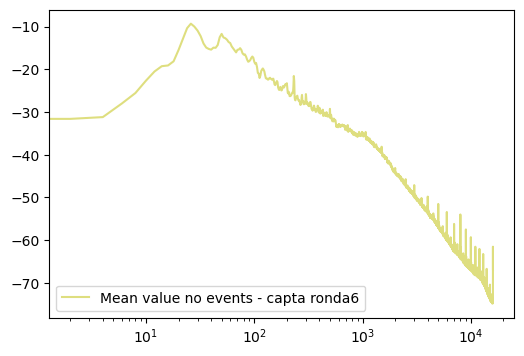

In [115]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig = plt.figure(figsize=(6,4))
mean_value_r6 = []

for f in range(len(data_lower['class'])):
    clear_output(wait=True)
    print('capta')
    print('Lleva %d / %d' %(f, len(data_lower['class'])))   
            
    if (data_lower['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r6.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
mean_value_r6 = np.array(mean_value_r6)
mean_value_r6 = np.mean(mean_value_r6, axis=0)

#plt.semilogx(freq, mean_value_r1.T, 'b', label='Mean value no events - capta ronda1', alpha=0.5)
#plt.semilogx(freq, mean_value_r2.T, 'g', label='Mean value no events - capta ronda2', alpha=0.5)
#plt.semilogx(freq, mean_value_r3.T, 'r', label='Mean value no events - capta ronda3', alpha=0.5)
plt.semilogx(freq, mean_value_r6.T, 'y', label='Mean value no events - capta ronda6', alpha=0.5)
#################################################


plt.legend()

In [133]:
## r6
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig = plt.figure(figsize=(6,4))
mean_value_event_r6 = []
mean_value_r6 = []

for f in range(len(data_event['class'])):
    clear_output(wait=True)
    print('events')
    print('Lleva %d / %d' %(f, len(data_event['class'])))   
    
    if (data_event['station'].loc[f]=='ronda6/'):
        print('hola')
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r6.append(normalized_psd_dB)
        #print(mean_value_event_r6)



events
Lleva 7678 / 7679
hola


<Figure size 600x400 with 0 Axes>

In [141]:
print(mean_value_event_r6[1][0])

[-32.286865 -33.374287 -36.55156  ... -80.723045 -76.12398  -79.274765]


In [142]:
print(mean_value_event_r6[0][0])

[-32.348724 -35.887386 -45.979202 ... -76.655205 -73.122856 -76.019226]


In [129]:
mean_value_event_r6 = np.mean(mean_value_event_r6, axis=0)
print(mean_value_event_r6)

[[nan nan nan ... nan nan nan]]


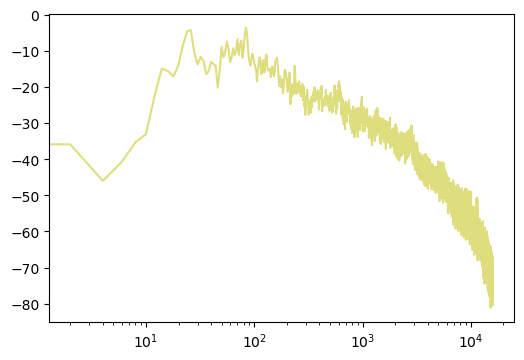

In [128]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r6[0].T, 'y', label='Mean value no events - capta ronda6', alpha=0.5)    

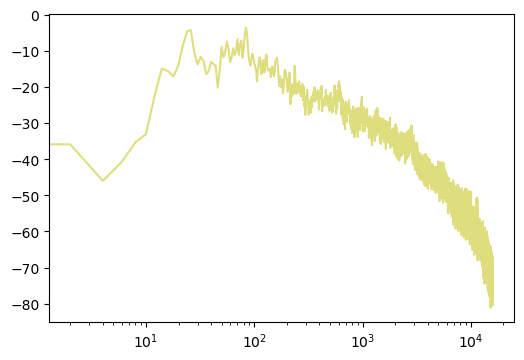

In [111]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r6[0].T, 'y', label='Mean value events - capta ronda6', alpha=0.5)    

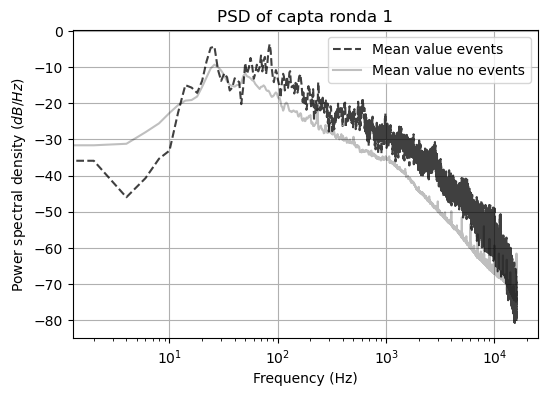

In [117]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r6[0].T, 'k', label='Mean value events', linestyle='dashed', alpha=0.75)
plt.semilogx(freq, mean_value_r6.T, 'k', label='Mean value no events', alpha=0.25)
#plt.xlim([100, freq.max()])
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$') 
plt.title('PSD of capta ronda 1', fontsize=12)
plt.grid(True)
plt.legend()

In [110]:
mean_value_event_r6[0].shape

(1, 8001)

In [ ]:
# r6 2
if (data_lower['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r6.append(normalized_psd_dB)
        #fig.add_subplot(111)
        axes[0].semilogx(freq, normalized_psd_dB.T, color='grey', lw=1, alpha=0.01)
        
        if b_r6:
            axes[0].semilogx(freq, normalized_psd_dB.T, color='grey', lw=1, alpha=0.5, label='PSD no events: capta ronda6')
            b_r6=False

        
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    

mean_value_event_r6 = np.array(mean_value_event_r6)
std_dev_value_event_r6 = np.std(mean_value_event_r6, axis = 0)
mean_value_event_r6 = np.mean(mean_value_event_r6, axis=0)


#plt.semilogx(freq, mean_value_event_r6.T, 'y', label='Mean value events - r6', linestyle='dashed', alpha=0.5)
#####################################################

for f in range(len(data_lower['class'])):
    clear_output(wait=True)
    print('capta')
    print('Lleva %d / %d' %(f, len(data_lower['class'])))   
    if (data_lower['station'].loc[f]=='ronda1/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r1.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
    if (data_lower['station'].loc[f]=='ronda2/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r2.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
            
    if (data_lower['station'].loc[f]=='ronda3/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r3.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
    if (data_lower['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r6.append(normalized_psd_dB)
        #fig.add_subplot(111)
        

#plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    
mean_value_r1 = np.array(mean_value_r1)
mean_value_r2 = np.array(mean_value_r2)
mean_value_r3 = np.array(mean_value_r3)
mean_value_r6 = np.array(mean_value_r6)



mean_value_r1 = np.mean(mean_value_r1, axis=0)
mean_value_r2 = np.mean(mean_value_r2, axis=0)
mean_value_r3 = np.mean(mean_value_r3, axis=0)
mean_value_r6 = np.mean(mean_value_r6, axis=0)

plt.semilogx(freq, mean_value_r1.T, 'b', label='Mean value no events - capta ronda1', alpha=0.5)
#plt.semilogx(freq, mean_value_r2.T, 'g', label='Mean value no events - capta ronda2', alpha=0.5)
#plt.semilogx(freq, mean_value_r3.T, 'r', label='Mean value no events - capta ronda3', alpha=0.5)
#plt.semilogx(freq, mean_value_r6.T, 'y', label='Mean value no events - capta ronda6', alpha=0.5)
#################################################

for f in range(len(data_upper['class'])):
    clear_output(wait=True)
    print('ca-mma')
    print('Lleva %d / %d' %(f, len(data_upper['class'])))  
    if (data_upper['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_ca.append(normalized_psd_dB)
       
    if (data_upper['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_mma.append(normalized_psd_dB)
       
        
mean_value_mma = np.array(mean_value_mma)
mean_value_ca = np.array(mean_value_ca)
mean_value_mma = np.mean(mean_value_mma, axis=0)
mean_value_ca = np.mean(mean_value_ca, axis=0)


plt.semilogx(freq, mean_value_ca.T, 'm', label='Mean value no events - ca'  , alpha=0.5)
plt.semilogx(freq, mean_value_mma.T, 'c', label='Mean value no events - mma', alpha=0.5) 
plt.legend()


ca-mma
Lleva 314 / 315


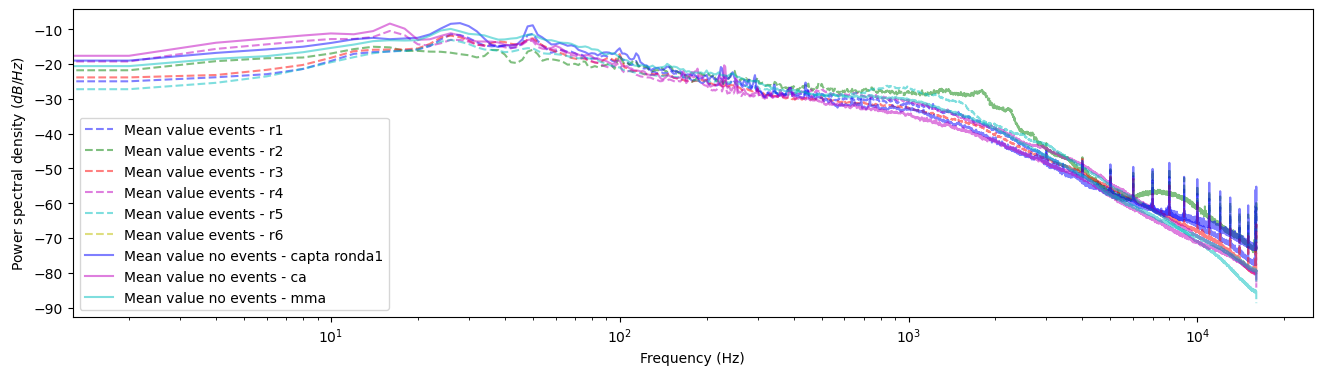

In [17]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig = plt.figure(figsize=(6,4))
mean_value_event_r1 = []
mean_value_event_r2 = []
mean_value_event_r3 = []
mean_value_event_r4 = []
mean_value_event_r5 = []
mean_value_event_r6 = []

mean_value_mma = []
mean_value_ca = []
mean_value_r1 = []
mean_value_r2 = []
mean_value_r3 = []
mean_value_r6 = []

for f in range(len(data_event['class'])):
    clear_output(wait=True)
    print('events')
    print('Lleva %d / %d' %(f, len(data_event['class'])))   
    if (data_event['station'].loc[f]=='ronda1/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r1.append(normalized_psd_dB)
            
    if (data_event['station'].loc[f]=='ronda2/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r2.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda3/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r3.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r4.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r5.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r6.append(normalized_psd_dB)

        
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    

mean_value_event_r1 = np.array(mean_value_event_r1)
std_dev_value_event_r1 = np.std(mean_value_event_r1, axis = 0)
mean_value_event_r1 = np.mean(mean_value_event_r1, axis=0)
plt.semilogx(freq, mean_value_event_r1.T, 'b', label='Mean value events - r1', linestyle='dashed', alpha=0.5)

mean_value_event_r2 = np.array(mean_value_event_r2)
std_dev_value_event_r2 = np.std(mean_value_event_r2, axis = 0)
mean_value_event_r2 = np.mean(mean_value_event_r2, axis=0)
#plt.semilogx(freq, mean_value_event_r2.T, 'g', label='Mean value events - r2', linestyle='dashed', alpha=0.5)

mean_value_event_r3 = np.array(mean_value_event_r3)
std_dev_value_event_r3 = np.std(mean_value_event_r3, axis = 0)
mean_value_event_r3 = np.mean(mean_value_event_r3, axis=0)
#plt.semilogx(freq, mean_value_event_r3.T, 'r', label='Mean value events - r3', linestyle='dashed', alpha=0.5)

mean_value_event_r4 = np.array(mean_value_event_r4)
std_dev_value_event_r4 = np.std(mean_value_event_r4, axis = 0)
mean_value_event_r4 = np.mean(mean_value_event_r4, axis=0)
#plt.semilogx(freq, mean_value_event_r4.T, 'm', label='Mean value events - r4', linestyle='dashed', alpha=0.5)

mean_value_event_r5 = np.array(mean_value_event_r5)
std_dev_value_event_r5 = np.std(mean_value_event_r5, axis = 0)
mean_value_event_r5 = np.mean(mean_value_event_r5, axis=0)
#plt.semilogx(freq, mean_value_event_r5.T, 'c', label='Mean value events - r5', linestyle='dashed', alpha=0.5)

mean_value_event_r6 = np.array(mean_value_event_r6)
std_dev_value_event_r6 = np.std(mean_value_event_r6, axis = 0)
mean_value_event_r6 = np.mean(mean_value_event_r6, axis=0)
#plt.semilogx(freq, mean_value_event_r6.T, 'y', label='Mean value events - r6', linestyle='dashed', alpha=0.5)
#####################################################

for f in range(len(data_lower['class'])):
    clear_output(wait=True)
    print('capta')
    print('Lleva %d / %d' %(f, len(data_lower['class'])))   
    if (data_lower['station'].loc[f]=='ronda1/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r1.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
    if (data_lower['station'].loc[f]=='ronda2/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r2.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
            
    if (data_lower['station'].loc[f]=='ronda3/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r3.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
    if (data_lower['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r6.append(normalized_psd_dB)
        #fig.add_subplot(111)
        

#plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    
mean_value_r1 = np.array(mean_value_r1)
mean_value_r2 = np.array(mean_value_r2)
mean_value_r3 = np.array(mean_value_r3)
mean_value_r6 = np.array(mean_value_r6)



mean_value_r1 = np.mean(mean_value_r1, axis=0)
mean_value_r2 = np.mean(mean_value_r2, axis=0)
mean_value_r3 = np.mean(mean_value_r3, axis=0)
mean_value_r6 = np.mean(mean_value_r6, axis=0)

plt.semilogx(freq, mean_value_r1.T, 'b', label='Mean value no events - capta ronda1', alpha=0.5)
#plt.semilogx(freq, mean_value_r2.T, 'g', label='Mean value no events - capta ronda2', alpha=0.5)
#plt.semilogx(freq, mean_value_r3.T, 'r', label='Mean value no events - capta ronda3', alpha=0.5)
#plt.semilogx(freq, mean_value_r6.T, 'y', label='Mean value no events - capta ronda6', alpha=0.5)
#################################################

for f in range(len(data_upper['class'])):
    clear_output(wait=True)
    print('ca-mma')
    print('Lleva %d / %d' %(f, len(data_upper['class'])))  
    if (data_upper['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_ca.append(normalized_psd_dB)
       
    if (data_upper['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_mma.append(normalized_psd_dB)
       
        
mean_value_mma = np.array(mean_value_mma)
mean_value_ca = np.array(mean_value_ca)
mean_value_mma = np.mean(mean_value_mma, axis=0)
mean_value_ca = np.mean(mean_value_ca, axis=0)


plt.semilogx(freq, mean_value_ca.T, 'm', label='Mean value no events - ca'  , alpha=0.5)
plt.semilogx(freq, mean_value_mma.T, 'c', label='Mean value no events - mma', alpha=0.5) 
plt.legend()

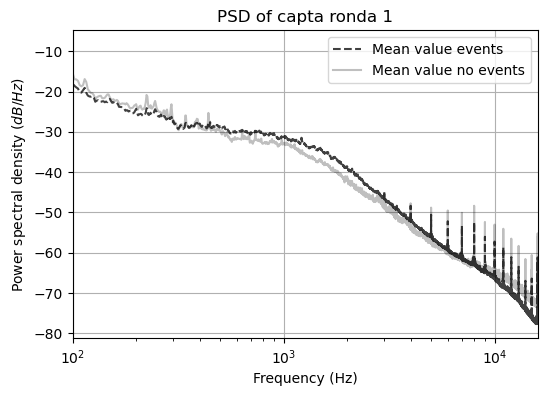

In [55]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r1.T, 'k', label='Mean value events', linestyle='dashed', alpha=0.75)
plt.semilogx(freq, mean_value_r1.T, 'k', label='Mean value no events', alpha=0.25)
plt.xlim([100, freq.max()])
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$') 
plt.title('PSD of capta ronda 1', fontsize=12)
plt.grid(True)
plt.legend()

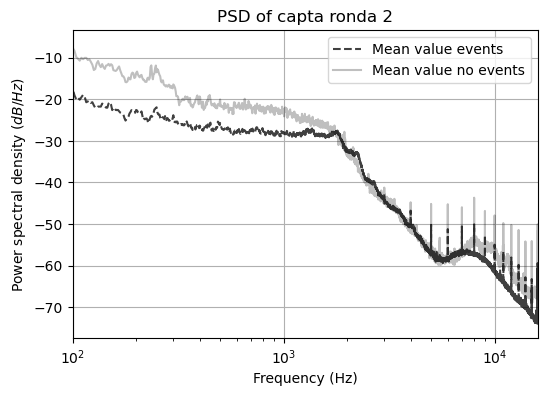

In [54]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r2.T, 'k', label='Mean value events', linestyle='dashed', alpha=0.75)
plt.semilogx(freq, mean_value_r2.T, 'k', label='Mean value no events', alpha=0.25)
plt.xlim([100, freq.max()])
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$') 
plt.title('PSD of capta ronda 2', fontsize=12)
plt.grid(True)
plt.legend()

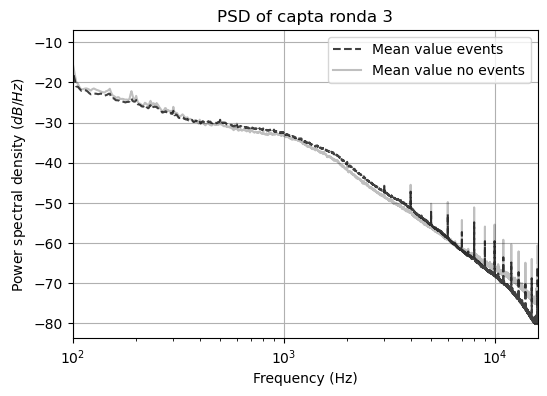

In [53]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r3.T, 'k', label='Mean value events', linestyle='dashed', alpha=0.75)
plt.semilogx(freq, mean_value_r3.T, 'k', label='Mean value no events', alpha=0.25)
plt.xlim([100, freq.max()])
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$') 
plt.title('PSD of capta ronda 3', fontsize=12)
plt.grid(True)
plt.legend()

In [114]:
mean_value_r6

[]

In [47]:
mean_value_event_r6

array([[nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

IndexError: list index out of range

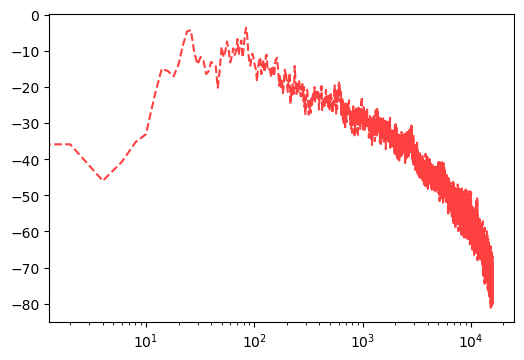

In [113]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r6[0].T, 'r', label='Mean value events', linestyle='dashed', alpha=0.75)
plt.semilogx(freq, mean_value_r6[0].T, 'k', label='Mean value no events', alpha=0.25)
#plt.xlim([20, freq.max()])
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$') 
plt.title('PSD of capta ronda 6', fontsize=12)
plt.grid(True)
plt.legend()

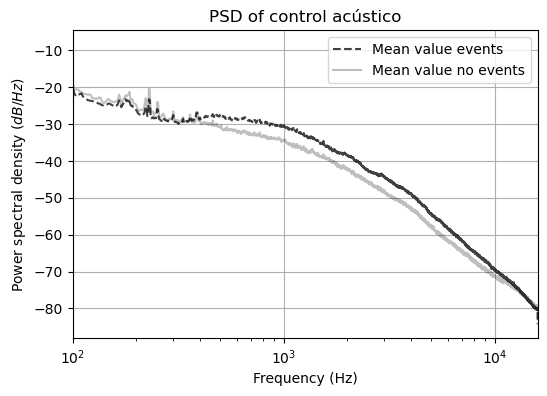

In [52]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r4.T, 'k', label='Mean value events', linestyle='dashed', alpha=0.75)
plt.semilogx(freq, mean_value_ca.T, 'k', label='Mean value no events', alpha=0.25)
plt.xlim([100, freq.max()])
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$') 
plt.title('PSD of control acústico', fontsize=12)
plt.grid(True)
plt.legend()

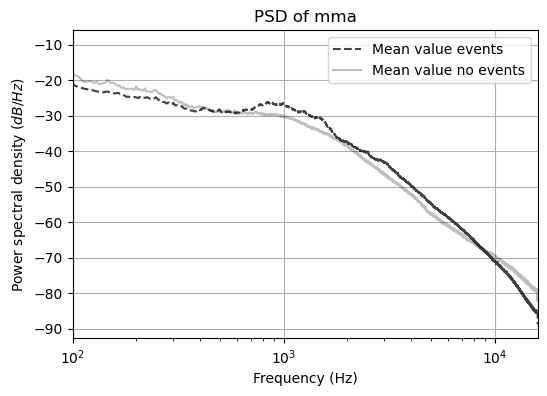

In [59]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(freq, mean_value_event_r5.T, 'k', label='Mean value events', linestyle='dashed', alpha=0.75)
plt.semilogx(freq, mean_value_mma.T, 'k', label='Mean value no events', alpha=0.25) 
plt.xlim([100, freq.max()])
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$') 
plt.title('PSD of mma', fontsize=12)
plt.grid(True)
plt.legend()

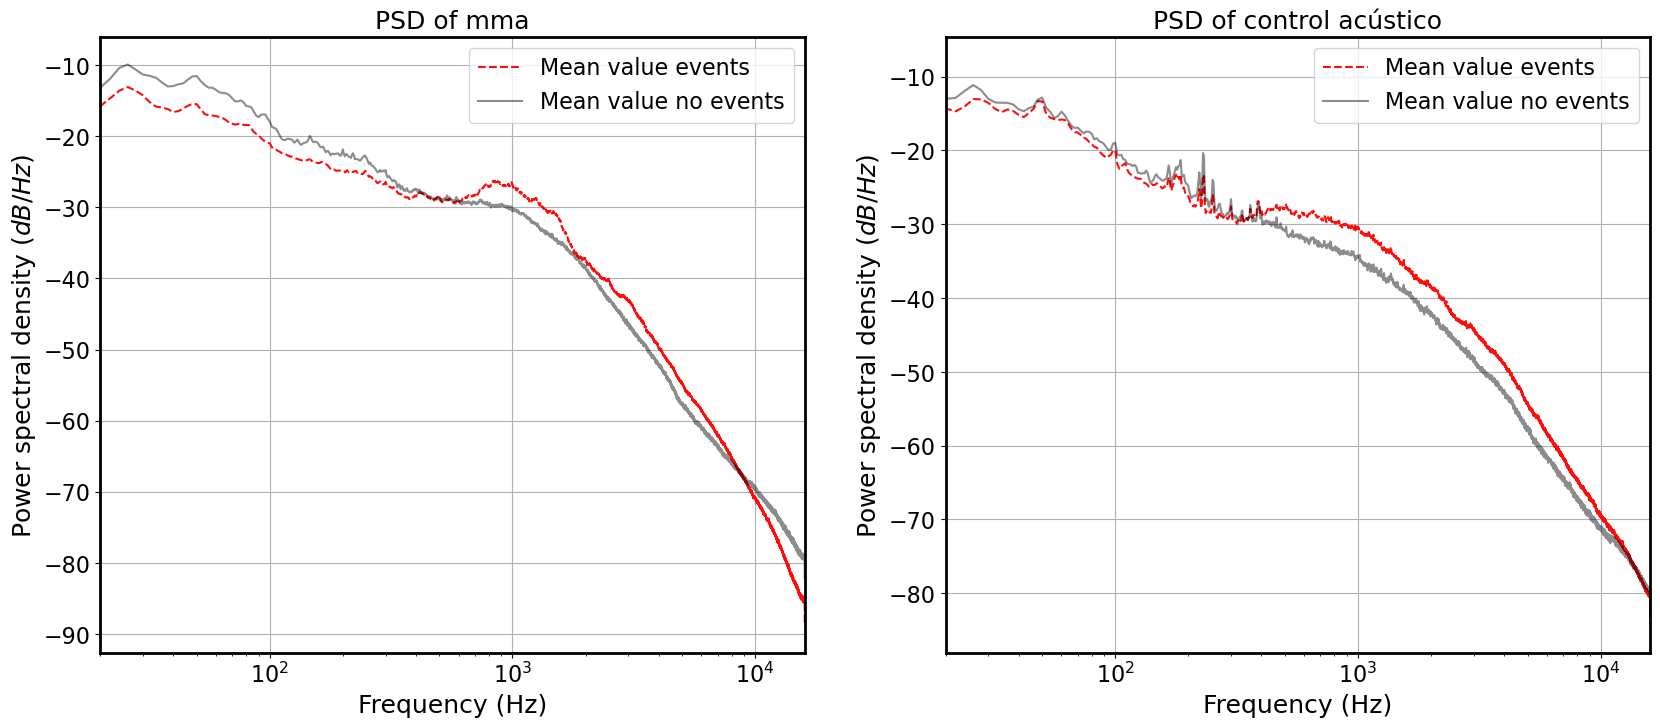

In [78]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
        
axes[0].semilogx(freq, mean_value_event_r5.T, 'r', label='Mean value events', linestyle='dashed', alpha=0.95)
axes[0].semilogx(freq, mean_value_mma.T, 'k', label='Mean value no events', alpha=0.45)
axes[0].grid(True)
axes[0].set_xlabel( 'Frequency (Hz)', fontsize=18)
axes[0].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()): 
    label.set_fontsize(16)

for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(2)
axes[0].set_title('PSD of mma', fontsize=18)
axes[0].set_xlim([20, freq.max()])
axes[0].legend(fontsize = 16)

axes[1].semilogx(freq, mean_value_event_r4.T, 'r', label='Mean value events', linestyle='dashed', alpha=0.95)
axes[1].semilogx(freq, mean_value_ca.T, 'k', label='Mean value no events', alpha=0.45)

axes[1].grid(True)
axes[1].set_xlabel( 'Frequency (Hz)', fontsize=18)
axes[1].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()): 
    label.set_fontsize(16)

for axis in ['top','bottom','left','right']:
    axes[1].spines[axis].set_linewidth(2)
axes[1].set_title('PSD of control acústico', fontsize=18)
axes[1].set_xlim([20, freq.max()])
axes[1].legend(fontsize = 16)

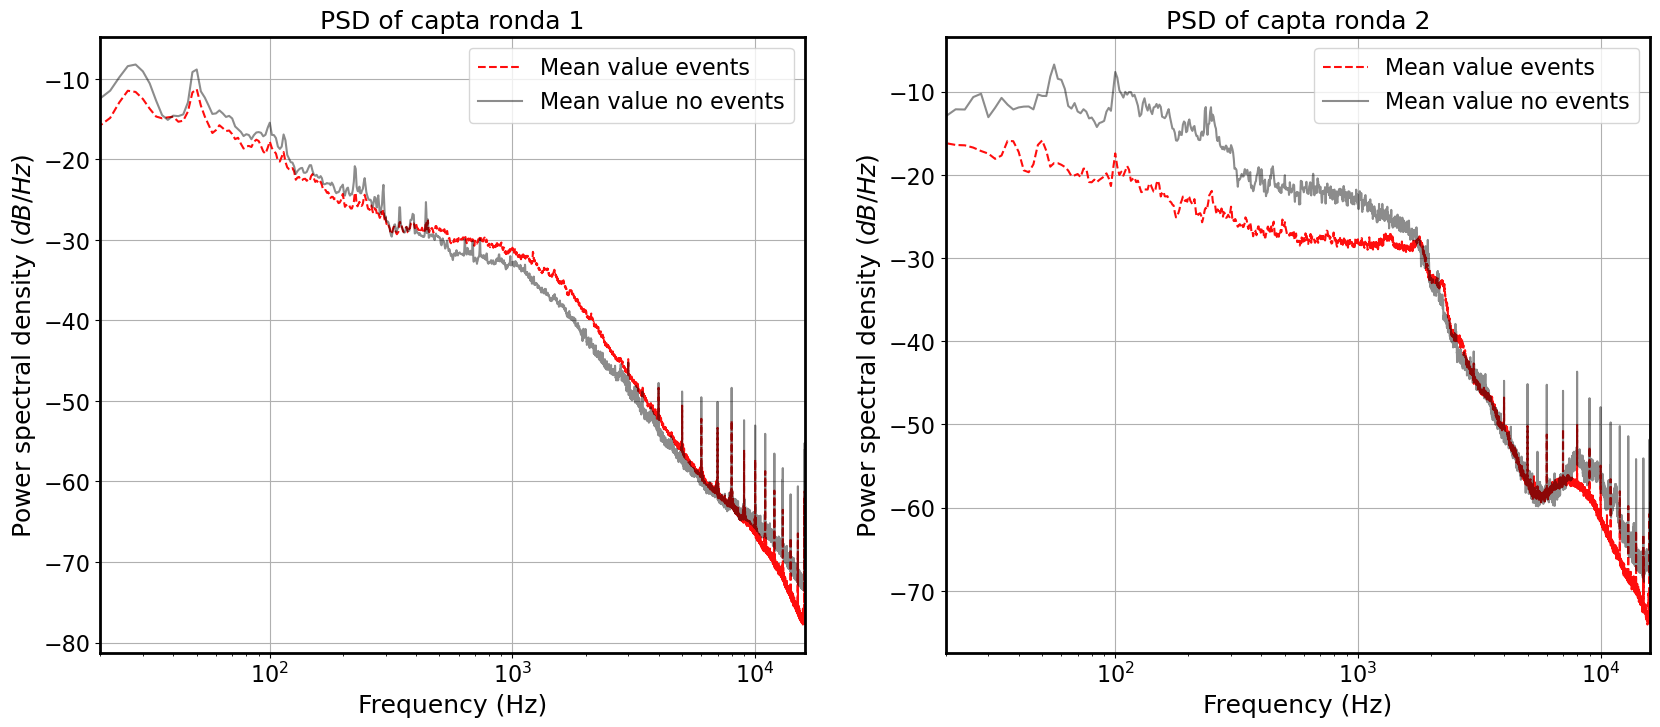

In [82]:
fig, axes = plt.subplots(1,2, figsize=(20,8))

axes[0].semilogx(freq, mean_value_event_r1.T, 'r', label='Mean value events', linestyle='dashed', alpha=0.95)
axes[0].semilogx(freq, mean_value_r1.T, 'k', label='Mean value no events', alpha=0.45)
axes[0].grid(True)
axes[0].set_xlabel( 'Frequency (Hz)', fontsize=18)
axes[0].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()): 
    label.set_fontsize(16)

for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(2)
axes[0].set_title('PSD of capta ronda 1', fontsize=18)
axes[0].set_xlim([20, freq.max()])
axes[0].legend(fontsize = 16)

axes[1].semilogx(freq, mean_value_event_r2.T, 'r', label='Mean value events', linestyle='dashed', alpha=0.95)
axes[1].semilogx(freq, mean_value_r2.T, 'k', label='Mean value no events', alpha=0.45)
axes[1].grid(True)
axes[1].set_xlabel( 'Frequency (Hz)', fontsize=18)
axes[1].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()): 
    label.set_fontsize(16)

for axis in ['top','bottom','left','right']:
    axes[1].spines[axis].set_linewidth(2)
axes[1].set_title('PSD of capta ronda 2', fontsize=18)
axes[1].set_xlim([20, freq.max()])
axes[1].legend(fontsize = 16)

In [ ]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig = plt.figure(figsize=(20,8))
mean_value_event_r1 = []
mean_value_event_r2 = []
mean_value_event_r3 = []
mean_value_event_r4 = []
mean_value_event_r5 = []
mean_value_event_r6 = []

mean_value_mma = []
mean_value_ca = []
mean_value_r1 = []
mean_value_r2 = []
mean_value_r3 = []
mean_value_r6 = []

for f in range(len(data_event['class'])):
    clear_output(wait=True)
    print('events')
    print('Lleva %d / %d' %(f, len(data_event['class'])))   
    if (data_event['station'].loc[f]=='ronda1/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r1.append(normalized_psd_dB)
            
    if (data_event['station'].loc[f]=='ronda2/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r2.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda3/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r3.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r4.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r5.append(normalized_psd_dB)
        
    if (data_event['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_event['station'].loc[f] + 'audios_all_classes/'+ data_event.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_event_r6.append(normalized_psd_dB)

        
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    

mean_value_event_r1 = np.array(mean_value_event_r1)
std_dev_value_event_r1 = np.std(mean_value_event_r1, axis = 0)
mean_value_event_r1 = np.mean(mean_value_event_r1, axis=0)
plt.semilogx(freq, mean_value_event_r1.T, 'b', label='Mean value events - r1', linestyle='dashed', alpha=0.5)

mean_value_event_r2 = np.array(mean_value_event_r2)
std_dev_value_event_r2 = np.std(mean_value_event_r2, axis = 0)
mean_value_event_r2 = np.mean(mean_value_event_r2, axis=0)
plt.semilogx(freq, mean_value_event_r2.T, 'g', label='Mean value events - r2', linestyle='dashed', alpha=0.5)

mean_value_event_r3 = np.array(mean_value_event_r3)
std_dev_value_event_r3 = np.std(mean_value_event_r3, axis = 0)
mean_value_event_r3 = np.mean(mean_value_event_r3, axis=0)
plt.semilogx(freq, mean_value_event_r3.T, 'r', label='Mean value events - r3', linestyle='dashed', alpha=0.5)

mean_value_event_r4 = np.array(mean_value_event_r4)
std_dev_value_event_r4 = np.std(mean_value_event_r4, axis = 0)
mean_value_event_r4 = np.mean(mean_value_event_r4, axis=0)
plt.semilogx(freq, mean_value_event_r4.T, 'm', label='Mean value events - r4', linestyle='dashed', alpha=0.5)

mean_value_event_r5 = np.array(mean_value_event_r5)
std_dev_value_event_r5 = np.std(mean_value_event_r5, axis = 0)
mean_value_event_r5 = np.mean(mean_value_event_r5, axis=0)
plt.semilogx(freq, mean_value_event_r5.T, 'c', label='Mean value events - r5', linestyle='dashed', alpha=0.5)

mean_value_event_r6 = np.array(mean_value_event_r6)
std_dev_value_event_r6 = np.std(mean_value_event_r6, axis = 0)
mean_value_event_r6 = np.mean(mean_value_event_r6, axis=0)
plt.semilogx(freq, mean_value_event_r6.T, 'y', label='Mean value events - r6', linestyle='dashed', alpha=0.5)
#####################################################

for f in range(len(data_lower['class'])):
    clear_output(wait=True)
    print('capta')
    print('Lleva %d / %d' %(f, len(data_lower['class'])))   
    if (data_lower['station'].loc[f]=='ronda1/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r1.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
    if (data_lower['station'].loc[f]=='ronda2/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r2.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
            
    if (data_lower['station'].loc[f]=='ronda3/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r3.append(normalized_psd_dB)
        #fig.add_subplot(111)
        
    if (data_lower['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r6.append(normalized_psd_dB)
        #fig.add_subplot(111)
        

#plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    
mean_value_r1 = np.array(mean_value_r1)
mean_value_r2 = np.array(mean_value_r2)
mean_value_r3 = np.array(mean_value_r3)
mean_value_r6 = np.array(mean_value_r6)



mean_value_r1 = np.mean(mean_value_r1, axis=0)
mean_value_r2 = np.mean(mean_value_r2, axis=0)
mean_value_r3 = np.mean(mean_value_r3, axis=0)
mean_value_r6 = np.mean(mean_value_r6, axis=0)

plt.semilogx(freq, mean_value_r1.T, 'b', label='Mean value no events - capta ronda1', alpha=0.5)
plt.semilogx(freq, mean_value_r2.T, 'g', label='Mean value no events - capta ronda2', alpha=0.5)
plt.semilogx(freq, mean_value_r3.T, 'r', label='Mean value no events - capta ronda3', alpha=0.5)
plt.semilogx(freq, mean_value_r6.T, 'y', label='Mean value no events - capta ronda6', alpha=0.5)
#################################################

for f in range(len(data_upper['class'])):
    clear_output(wait=True)
    print('ca-mma')
    print('Lleva %d / %d' %(f, len(data_upper['class'])))  
    if (data_upper['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_ca.append(normalized_psd_dB)
       
    if (data_upper['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_mma.append(normalized_psd_dB)
       
        
mean_value_mma = np.array(mean_value_mma)
mean_value_ca = np.array(mean_value_ca)
mean_value_mma = np.mean(mean_value_mma, axis=0)
mean_value_ca = np.mean(mean_value_ca, axis=0)


plt.semilogx(freq, mean_value_ca.T, 'm', label='Mean value no events - ca'  , alpha=0.5)
plt.semilogx(freq, mean_value_mma.T, 'c', label='Mean value no events - mma', alpha=0.5) 
plt.legend()

In [ ]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig = plt.figure(figsize=(20,8))
mean_value_event_r1 = []
mean_value_event_r2 = []
mean_value_event_r3 = []
mean_value_event_r4 = []
mean_value_event_r5 = []
mean_value_event_r6 = []

mean_value_mma = []
mean_value_ca = []
mean_value_r1 = []
mean_value_r2 = []
mean_value_r3 = []
mean_value_r6 = []


for f in range(len(data_upper['class'])):
    clear_output(wait=True)
    print('ca-mma')
    print('Lleva %d / %d' %(f, len(data_upper['class'])))  
    if (data_upper['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_ca.append(normalized_psd_dB)
       
    if (data_upper['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_mma.append(normalized_psd_dB)
       
        
mean_value_mma = np.array(mean_value_mma)
mean_value_ca = np.array(mean_value_ca)
mean_value_mma = np.mean(mean_value_mma, axis=0)
mean_value_ca = np.mean(mean_value_ca, axis=0)


plt.semilogx(freq, mean_value_ca.T, 'm', label='Mean value no events - ca'  , alpha=0.5)
plt.semilogx(freq, mean_value_mma.T, 'c', label='Mean value no events - mma', alpha=0.5) 

In [ ]:
for i in range(1,7):
    print("mean_value_event_r%d = np.array(mean_value_event_r%d)" %(i))
    print("std_dev_value_event_r%d = np.std(mean_value_event_r%d, axis = 0)" %(i,i))
    print("mean_value_event_r%d = np.mean(mean_value_event_r%d, axis=0)" %(i,i))
    print("plt.semilogx(freq, mean_value_event_r%d.T, 'k', label='Mean value events - r%d', linestyle='dashed')" %(i,i))
    print('')

In [ ]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig, axes = plt.subplots(1,2, figsize=(20,8))
mean_value_mma = []
mean_value_ca = []

for f in range(len(data_upper['class'])):
    
    if (data_upper['station'].loc[f]=='ronda4/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_ca.append(normalized_psd_dB)
        #fig.add_subplot(111)
        axes[0].semilogx(freq, normalized_psd_dB.T, color='b', lw=1, alpha=0.05)
        
        if f == 0:
            axes[0].semilogx(freq, normalized_psd_dB.T, color='b', lw=1, alpha=0.5, label='PSD no events: ca')
        
    if (data_upper['station'].loc[f]=='ronda5/'):
        
        wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_mma.append(normalized_psd_dB)
        #fig.add_subplot(111)
        axes[0].semilogx(freq, normalized_psd_dB.T, color='g', lw=1, alpha=0.05)
        
        if f == 140:
            axes[0].semilogx(freq, normalized_psd_dB.T, color='g', lw=1, alpha=0.5, label='PSD no events: mma')
        

#plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    
mean_value_mma = np.array(mean_value_mma)
mean_value_ca = np.array(mean_value_ca)

std_dev_value_mma = np.std(mean_value_mma, axis = 0)

mean_value_mma = np.mean(mean_value_mma, axis=0)

std_dev_value_ca = np.std(mean_value_ca, axis = 0)

mean_value_ca = np.mean(mean_value_ca, axis=0)


axes[0].semilogx(freq, mean_value_ca.T, 'k', label='Mean value no events - ca')
axes[0].semilogx(freq, mean_value_mma.T, 'r', label='Mean value no events - mma')
#axes[0].xlabel('Frequency (Hz)'), axes[0].ylabel('Power spectral density ($dB/Hz)$')
#
#plt.legend()

axes[1].semilogx(freq, mean_value_ca[0], 'k-', alpha=0.3, label='Mean value no events - ca')
axes[1].semilogx(freq, mean_value_mma[0], 'r-', alpha=0.3, label='Mean value no events - mma')
axes[1].fill_between(freq, mean_value_ca[0]-std_dev_value_ca[0], mean_value_ca[0]+std_dev_value_ca[0], alpha=0.3, label='Std value no events - ca')
axes[1].fill_between(freq, mean_value_mma[0]-std_dev_value_mma[0], mean_value_mma[0]+std_dev_value_mma[0], alpha=0.3, label='Std value no events - mma')
#axes[1].legend()
#axes[1].xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    axes[1]
axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')
#axes[0].set(xlabel= 'Frequency (Hz)', ylabel='Power spectral density ($dB/Hz)$')
axes[0].set_xlabel( 'Frequency (Hz)', fontsize=18)
axes[1].set_xlabel( 'Frequency (Hz)', fontsize=18)

axes[0].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
axes[1].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
#axes[1].set(xlabel= 'Frequency (Hz)', ylabel='Power spectral density ($dB/Hz)$')
axes[0].set_title('From UMAP - PSD of ca and mma', fontsize=18)
axes[1].set_title('From UMAP - PSD mean of ca and mma + std', fontsize=18)

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()): 
    label.set_fontsize(16)

for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()): 
    label.set_fontsize(16) 
    

/home/kasparov/miniconda3/envs/hvplot/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/kasparov/miniconda3/envs/hvplot/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



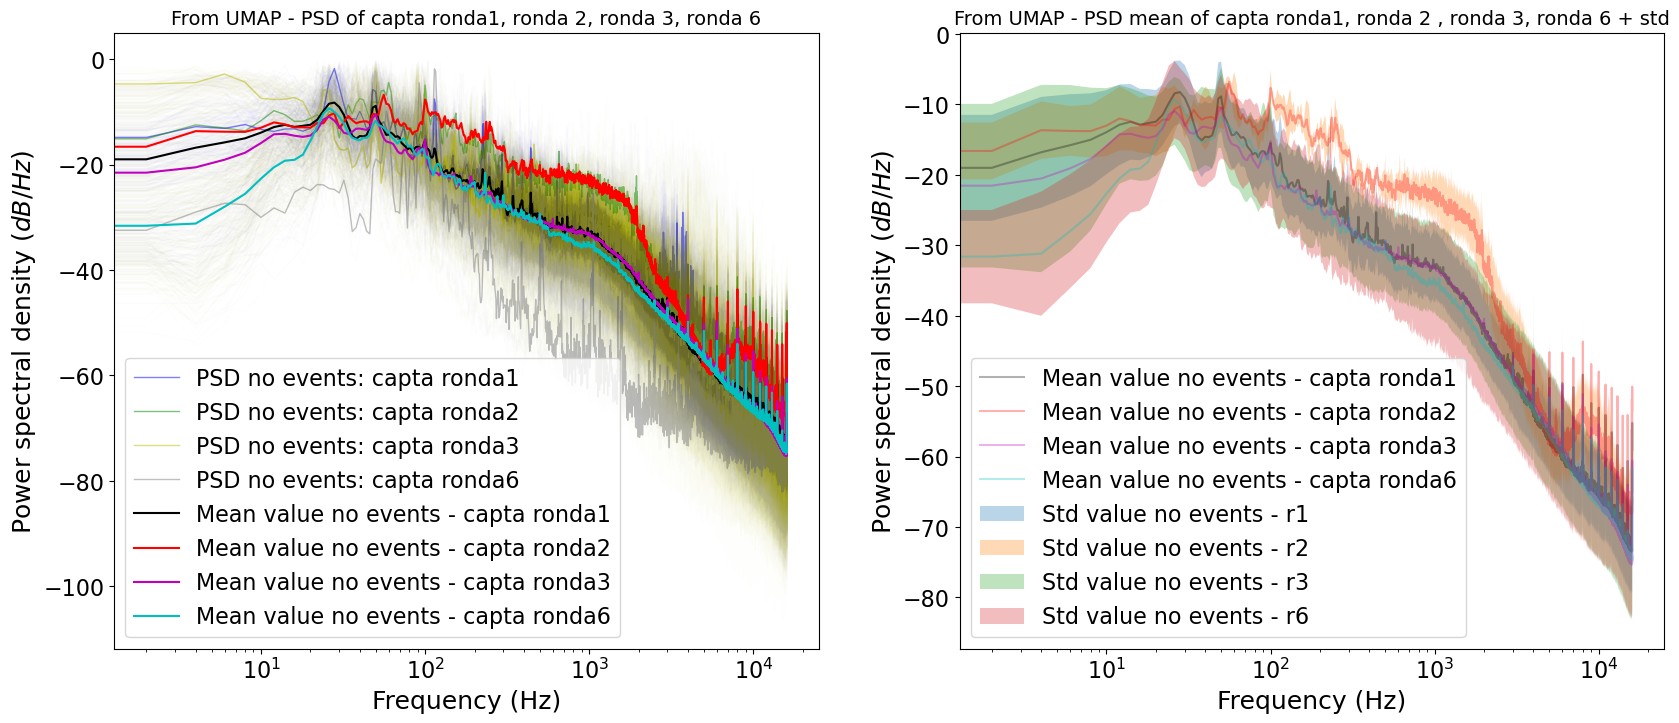

In [79]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig, axes = plt.subplots(1,2, figsize=(20,8))
mean_value_r1 = []
mean_value_r2 = []
mean_value_r3 = []
mean_value_r6 = []
b_r1 = True
b_r2 = True
b_r3 = True
b_r6 = True
for f in range(len(data_lower['class'])):
    
    if (data_lower['station'].loc[f]=='ronda1/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r1.append(normalized_psd_dB)
        #fig.add_subplot(111)
        axes[0].semilogx(freq, normalized_psd_dB.T, color='b', lw=1, alpha=0.01)
        
        if b_r1:
            axes[0].semilogx(freq, normalized_psd_dB.T, color='b', lw=1, alpha=0.5, label='PSD no events: capta ronda1')
            b_r1=False
    if (data_lower['station'].loc[f]=='ronda2/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r2.append(normalized_psd_dB)
        #fig.add_subplot(111)
        axes[0].semilogx(freq, normalized_psd_dB.T, color='g', lw=1, alpha=0.01)
        
        if b_r2:
            axes[0].semilogx(freq, normalized_psd_dB.T, color='g', lw=1, alpha=0.5, label='PSD no events: capta ronda2')
            b_r2=False
            
    if (data_lower['station'].loc[f]=='ronda3/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        mean_value_r3.append(normalized_psd_dB)
        #fig.add_subplot(111)
        axes[0].semilogx(freq, normalized_psd_dB.T, color='y', lw=1, alpha=0.01)
        
        if b_r3:
            axes[0].semilogx(freq, normalized_psd_dB.T, color='y', lw=1, alpha=0.5, label='PSD no events: capta ronda3')
            b_r3=False
    if (data_lower['station'].loc[f]=='ronda6/'):
        
        wav_file = main + data_lower['station'].loc[f] + 'ruido/'+ data_lower.loc[f].iat[3]
        freq, normalized_psd_dB = welch_periodogram(wav_file)
        
        mean_value_r6.append(normalized_psd_dB)
        #fig.add_subplot(111)
        axes[0].semilogx(freq, normalized_psd_dB.T, color='grey', lw=1, alpha=0.01)
        
        if b_r6:
            axes[0].semilogx(freq, normalized_psd_dB.T, color='grey', lw=1, alpha=0.5, label='PSD no events: capta ronda6')
            b_r6=False

#plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    
mean_value_r1 = np.array(mean_value_r1)
mean_value_r2 = np.array(mean_value_r2)
mean_value_r3 = np.array(mean_value_r3)
mean_value_r6 = np.array(mean_value_r6)

std_dev_value_r1 = np.std(mean_value_r1, axis = 0)

mean_value_r1 = np.mean(mean_value_r1, axis=0)

std_dev_value_r2 = np.std(mean_value_r2, axis = 0)

mean_value_r2 = np.mean(mean_value_r2, axis=0)

std_dev_value_r3 = np.std(mean_value_r3, axis = 0)

mean_value_r3 = np.mean(mean_value_r3, axis=0)

std_dev_value_r6 = np.std(mean_value_r6, axis = 0)

mean_value_r6 = np.mean(mean_value_r6, axis=0)


axes[0].semilogx(freq, mean_value_r1.T, 'k', label='Mean value no events - capta ronda1')
axes[0].semilogx(freq, mean_value_r2.T, 'r', label='Mean value no events - capta ronda2')
axes[0].semilogx(freq, mean_value_r3.T, 'm', label='Mean value no events - capta ronda3')
axes[0].semilogx(freq, mean_value_r6.T, 'c', label='Mean value no events - capta ronda6')
#axes[0].xlabel('Frequency (Hz)'), axes[0].ylabel('Power spectral density ($dB/Hz)$')
#
#plt.legend()

axes[1].semilogx(freq, mean_value_r1[0], 'k-', alpha=0.3, label='Mean value no events - capta ronda1')
axes[1].semilogx(freq, mean_value_r2[0], 'r-', alpha=0.3, label='Mean value no events - capta ronda2')
axes[1].semilogx(freq, mean_value_r3[0], 'm-', alpha=0.3, label='Mean value no events - capta ronda3')
axes[1].semilogx(freq, mean_value_r6[0], 'c-', alpha=0.3, label='Mean value no events - capta ronda6')

axes[1].fill_between(freq, mean_value_r1[0]-std_dev_value_r1[0], mean_value_r1[0]+std_dev_value_r1[0], alpha=0.3, label='Std value no events - r1')
axes[1].fill_between(freq, mean_value_r2[0]-std_dev_value_r2[0], mean_value_r2[0]+std_dev_value_r2[0], alpha=0.3, label='Std value no events - r2')
axes[1].fill_between(freq, mean_value_r3[0]-std_dev_value_r3[0], mean_value_r3[0]+std_dev_value_r3[0], alpha=0.3, label='Std value no events - r3')
axes[1].fill_between(freq, mean_value_r6[0]-std_dev_value_r6[0], mean_value_r6[0]+std_dev_value_r6[0], alpha=0.3, label='Std value no events - r6')

#axes[1].legend()
#axes[1].xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    axes[1]
axes[0].legend(loc='lower left')
axes[1].legend(loc='lower left')
#axes[0].set(xlabel= 'Frequency (Hz)', ylabel='Power spectral density ($dB/Hz)$')
axes[0].set_xlabel( 'Frequency (Hz)', fontsize=18)
axes[1].set_xlabel( 'Frequency (Hz)', fontsize=18)

axes[0].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
axes[1].set_ylabel( 'Power spectral density ($dB/Hz)$', fontsize=18)
#axes[1].set(xlabel= 'Frequency (Hz)', ylabel='Power spectral density ($dB/Hz)$')
axes[0].set_title('From UMAP - PSD of capta ronda1, ronda 2, ronda 3, ronda 6', fontsize=14)
axes[1].set_title('From UMAP - PSD mean of capta ronda1, ronda 2 , ronda 3, ronda 6 + std', fontsize=14)

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()): 
    label.set_fontsize(16)

for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()): 
    label.set_fontsize(16) 
    

In [ ]:
plt.show()
plt.semilogx(freq, std_dev_value.T, alpha=0.25)

In [ ]:
len(mean_value_ca)

In [ ]:
plt.semilogx(freq, mean_value_ca[0], 'k-', alpha=0.3, label='Mean value no events - ca')
plt.semilogx(freq, mean_value_mma[0], 'r-', alpha=0.3, label='Mean value no events - mma')
plt.fill_between(freq, mean_value_ca[0]-std_dev_value_ca[0], mean_value_ca[0]+std_dev_value_ca[0], alpha=0.3, label='Std value no events - ca')
plt.fill_between(freq, mean_value_mma[0]-std_dev_value_mma[0], mean_value_mma[0]+std_dev_value_mma[0], alpha=0.3, label='Std value no events - mma')
plt.legend()
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    

In [ ]:
plt.show()

In [ ]:
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' 

fig = plt.figure()
mean_value = []
for f in range(len(data_upper['class'])):
    
    #if f<=len(data_upper_r4):
        
    wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
    freq, normalized_psd_dB = welch_periodogram(wav_file)
    mean_value.append(normalized_psd_dB)
    #fig.add_subplot(111)
    plt.semilogx(freq, normalized_psd_dB.T, color='k', lw=1, alpha=0.05)
        
        #if f == 0:
            #plt.semilogx(freq, normalized_psd_dB.T, color='k', lw=1, alpha=0.3, label='PSD no events: mma, ca')
        
    #if (len(data_upper_r4) <f) and (f<=len(data_upper_r5)):
        
        #wav_file = main + data_upper['station'].loc[f] + 'ruido/'+ data_upper.loc[f].iat[3]
        #freq, normalized_psd_dB = welch_periodogram(wav_file)
        #mean_value.append(normalized_psd_dB)
        ##fig.add_subplot(111)
        #plt.semilogx(freq, normalized_psd_dB.T, color='k', lw=1, alpha=0.05)
        

plt.xlabel('Frequency (Hz)'), plt.ylabel('Power spectral density ($dB/Hz)$')    
mean_value = np.array(mean_value)
std_dev_value = np.std(mean_value, axis = 0)

mean_value = np.mean(mean_value, axis=0)



plt.semilogx(freq, mean_value.T, 'r', label='Mean value no events')
plt.legend()

In [ ]:
for a in [1.0, 2.0, 3.0]:
    plt.plot(x, a*x)

plt.show()

In [ ]:
result = 0.0008**2
result


In [ ]:
data_lower = lower.reset_index()
data_lower 

In [ ]:
a = 22
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_lower['station'].loc[a] + 'ruido/'
wav_file = main + data_lower.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

#### Spectral analysys and spectral slope

+ Different acoustic features of components such as spectral slope, bands of frequencies and their temporal properties can be evaluated to detect and reject audio signals.

+ Spectral ratios indicate dominant frequency.

+ Spectral ratios and spectral analysis may be used to distinguish between noise and signal.

+ Event (E)-to-No Event (NE) Component Spectral Ratio

+ The E-to-NE Spectral Power amplitude ratio called $E/NE_{\text{Spectral\_ratio}}$ for two spectral components: event spectra and no-event spectra are calculated. The calculation is shown by the following equation 

$$
\begin{align*}
E/(NE)_{\text{Spectral\_ratio}} &=
\end{align*}
$$

#### Compute the average bandpower of the signals

+ We are going to compute the average power of the signals in a specific frequency range from an auditory  perceptual point of view.

+ To do this, we are going to use both Welch and the multitaper spectral estimation methods. 

+ This computing is mainly generated for gaining insights about the signal processing in the context of the quality of sound event, or, no event chunks.

#### Distinct frequency bands

+ We are most sensitive to sounds in the range of 1,000 – 3,000 Hz.
+ The method to analyze the audio data is based on the decomposition of the signal into functionally distinct frequency bands, such as band1 (600–1500 Hz), band2 (1600–2500 Hz), band3 (2600–3500 Hz).

#### Average band power metric 

+ The average band power consists in computing a single number that summarizes the contribution of the given frequency band to the overall power of the signal.

+ The procedure implies the decomposition of the signal into frequency components using the Fourier transform, that is basically, the Fast Fourier Transform (FFT). It returns, for each frequency bin, a complex number from which one can then easily extract the amplitude and phase of the signal at that specific frequency. 

+ In the spectral analysis, we take the magnitude-squared of the FFT to obtain an estimate of the power spectral density, expressed in (micro)-Volts2 per Hertz in the case of data.

#### Usefulness of the metric average band power

+ The metric is particularly useful because we want to extract some keys features from the data and have a single number that summarizes a particular aspect of the data.

+ The average band power is also a very relevant metric for this research because it allows to differentiate between noise and signal. 

+ For instance, noise is characterized by a steep spectral slope at high frequencies in the PSD curves.

its slope of slow-waves with a frequency range comprised between 0.5 to 4 Hz (i.e. delta band), which reflects a synchronized brain activity. Conversely, wakefulness is characterized by very little delta activity and much more higher-frequencies activity. Therefore, if you were to compute the delta bandpower for both deep sleep and wakefulness, the former would be very high and the latter very low. See for yourself below:

In [ ]:
a = 15
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_miniball['station'].loc[a] + 'ruido/'
wav_file = main + data_miniball.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)
sample_rate

In [ ]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

In [ ]:
plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

In [ ]:
plot_waveform(resampled_waveform, resample_rate, title="Resampled Waveform")
plot_specgram(resampled_waveform, resample_rate)
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

#### Compute the average bandpower of a no-event signal

+ We are most sensitive to sounds in the range of 1,000 – 4,000 Hz.
+ The method to analyze the audio data is based on the decomposition of the signal into functionally distinct frequency bands, such as band1 (600–1500 Hz), band2 (1600–2500 Hz), band3 (2600–3500 Hz), and band4 (3600-4500 Hz).
+ Our lowest frequency of interest is 600 Hz so we will choose a window of 2/600 = 4 seconds

In [ ]:
lowest_freq = 600
window_choose = 2/600 #seconds
window_choose

In [ ]:
# Define window length (4 seconds)
win = window_choose * resample_rate #samples
win

freqs, psd = signal.welch(resampled_waveform, resample_rate, nperseg=win)
normalized_psd = psd[0] / np.linalg.norm(psd[0])
normalized_psd_dB = 10*np.log10(normalized_psd)

In [ ]:
plt.figure(figsize=(10,2))
#plt.plot(freqs, psd[0], color='k', lw=2)
plt.loglog(freqs, normalized_psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
#plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
plt.grid(True)
ax=plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
plt.show(block=False)

In [ ]:
freqs

In [ ]:
psd[0]

In [ ]:
# Define lower and upper limits
low, high   = 500, 1500
low2, high2 = 1500, 2500
low3, high3 = 2500, 3500
low4, high4 = 3500, 4500

# Find intersecting values in frequency vector
idx_band = np.logical_and(freqs >= low, freqs <= high)
idx_band2 = np.logical_and(freqs >= low2, freqs <= high2)
idx_band3 = np.logical_and(freqs >= low3, freqs <= high3)
idx_band4 = np.logical_and(freqs >= low4, freqs <= high4)

# Plot the power spectral density and fill the band area
plt.figure(figsize=(5,4))

#plt.loglog(freqs, normalized_psd, lw=2, color='k')
plt.semilogx(freqs, psd[0], lw=2, color='k')

plt.fill_between(freqs, psd[0], where=idx_band, color='silver')
plt.fill_between(freqs, psd[0], where=idx_band2, color='silver')
plt.fill_between(freqs, psd[0], where=idx_band3, color='silver')
plt.fill_between(freqs, psd[0], where=idx_band4, color='silver')

#plt.fill_between(freqs, normalized_psd, where=idx_band, color='silver')
#plt.fill_between(freqs, normalized_psd, where=idx_band2, color='silver')
#plt.fill_between(freqs, normalized_psd, where=idx_band3, color='silver')
#plt.fill_between(freqs, normalized_psd, where=idx_band4, color='silver')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
#plt.xlim([0, 6000])
#plt.ylim([0, psd.max() * 1.1])
plt.grid(True)
ax=plt.gca()
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
plt.show(block=False)

#### Absolute band power 
+  The absolute band power is equal to the area under the PSD curve and calculated by the integration method

In [ ]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  
freq_res
# Compute the absolute power by approximating the area under the curve
band_power1 = simps(psd[0][idx_band], dx=freq_res)
print('Absolute power: %.6f uV^2' % band_power1)

#### Again
+ https://notebook.community/JoseGuzman/myIPythonNotebooks/SignalProcessing/Welch's%20periodogram
+ The two normalizations necessary to obtain the amplitudes from the Fourier coefficients are:

> + 1) Divide the Fourier coefficients by the size of the signal 
> + 2) multipy by two to obtain the amplitude of the negative frequencies.

+ Additionally, we can set the DC-component to zero.

In [ ]:
waveform_ex = resampled_waveform.numpy()
waveform_ex[0]

In [ ]:
# Fourier transform
FourierCoeff = np.fft.fft(waveform_ex[0])/waveform_ex[0].size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nsamples = int( math.floor(waveform_ex[0].size/2) )
hz = np.linspace(0, resample_rate/2., num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%dhz)

In [ ]:
# Perform Welch's periodogram
segment = int( resample_rate*0.5 ) 
myhann = signal.get_window('hann', segment)

# obtain simply Power (amplitude^2) withouth tappering
myparams = dict(fs = resample_rate, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'spectrum', return_onesided=True)
freq, ps = signal.welch(x = waveform_ex[0], **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

#obtain Power density (amplitude^2/Hz) withouth tappering
myparams = dict(fs = resample_rate, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = waveform_ex[0], **myparams)# units uV**2/Hz
psd = 2*psd # correct for negative frequencies

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

In [ ]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].semilogx(freq, ps, color='k', lw=2) 
ax[1].set_ylabel('Power spectrum ($\mu V^2$)')
ax[1].set_xlabel('Frequency (Hz)')

In [ ]:
# Sine wave has an amplitude of 2 uV, the power is 4 uV and the power density is 4*4 because
# we took a segment with size = 4x the sampling rate
print('Signal amplitude     = %2.9f uVolts'%amp[int(0.0035/dhz)]) 
print('Signal power         = %2.9f uVolts^2'%ps[int(0.0035/dfreq)])
print('Singal power density = %2.9f uVolts^2/Hz'%psd[int(0.0035/dfreq)])

In [ ]:
waveform_ex = resampled_waveform.numpy()
waveform_ex[0]

In [ ]:
# Fourier transform
FourierCoeff = np.fft.fft(waveform_ex[0])/waveform_ex[0].size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nsamples = int( math.floor(waveform_ex[0].size/2) )
hz = np.linspace(0, resample_rate/2., num = Nsamples + 1 )
print('Spectral resolution = %2.4f Hz'%hz[1])

In [ ]:
# Perform Welch's periodogram with hann window and 50% overlap
segment = int( 0.5*resample_rate ) 
myhann = signal.get_window('hann', segment)


# obtain simply Power (uV^2) with Hann window and 50% overlap
myparams = dict(fs = resample_rate, nperseg = segment, window = myhann, 
                noverlap = segment/2, scaling = 'spectrum', return_onesided=True)

freq, ps = signal.welch(x = waveform_ex[0], **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

# obtain Power density (uV^2/Hz) with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = resample_rate, nperseg = segment, window = myhann, 
                 noverlap = segment/2, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = waveform_ex[0], **myparams2)# units uV**2
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

In [ ]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
#ax[0].semilogx(freq, np.sqrt(ps), color='brown', lw = 2)
ax[0].loglog(freq, np.sqrt(ps), color='brown', lw = 2)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power density (Welch's periodogram)")
#ax[1].semilogx(freq, psd, color='k', lw=2)
ax[1].loglog(freq, psd, color='k', lw=2)

ax[1].set_ylabel('Power spectrum density \n($\mu V^2/Hz$)')



In [ ]:
result = np.where(psd == np.amax(psd))
result
print(freq[result])

In [ ]:
# compute the signal at 1 Hz
print('Signal amplitude @200Hz     = %.15f uVolts'%amp[int(180/dhz)]) 
print('Signal power @200Hz         = %.15f uVolts^2'%ps[int(180/dfreq)])
print('Singal power density @200Hz = %.15f uVolts^2/Hz'%psd[int(180/dfreq)])

In [ ]:
# compute delta-band
idx_delta = np.logical_and(freq >= 600, freq <=1500)
band_power = simps(psd[idx_delta], dx = dfreq)
total_power = simps(psd, dx = dfreq)

print('Absolute power: %.15f uV^2' % delta_power)
print('Relative power: %.15f ' % (band_power/total_power))

In [ ]:
miniball

In [ ]:
miniball.info()

In [ ]:
columnas = miniball.columns
columnas = list(columnas)
columnas

In [ ]:
df2_miniball = miniball[['duration','power', 'Embedding 0', 'Embedding 1']]
print(df2_miniball.columns)

In [ ]:
a = 15
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_miniball['station'].loc[a] + 'ruido/'
wav_file = main + data_miniball.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

In [ ]:
import seaborn as sns
# a for loop to automate our task--------------
for i in df2_miniball.columns:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(df2_miniball[i], ax=ax_box , linewidth= 1.0)
    sns.histplot(df2_miniball[i], ax=ax_hist , bins = 80,kde=True)

In [ ]:
a = 15
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_miniball['station'].loc[a] + 'ruido/'
wav_file = main + data_miniball.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)